## **Example (1D)**

### **Set Environment**

In [ ]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, InnerProductProcessor
from lib.classical_functions import *
from lib.quantum_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# IonQ Simulator
# os.environ['IONQ_API_KEY'] = 'Your API Key'
provider = IonQProvider(os.getenv("IONQ_API_KEY"))
simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
simulator_backend.set_options(noise_model="ideal")

# IBM Hardware
hardware_backend = QiskitRuntimeService().least_busy()
print(hardware_backend.name)

ibm_yonsei


### **Initialize Sampler**

In [7]:
grid_num = 16
one_dim_grid_num = int(np.sqrt(grid_num))
num_shots = 2**19

options_sampler = SamplerOptions()
options_sampler.default_shots = num_shots
sampler = Sampler(mode = hardware_backend, options = options_sampler)

### **Design Ansatz**

Number of Parameters: 16


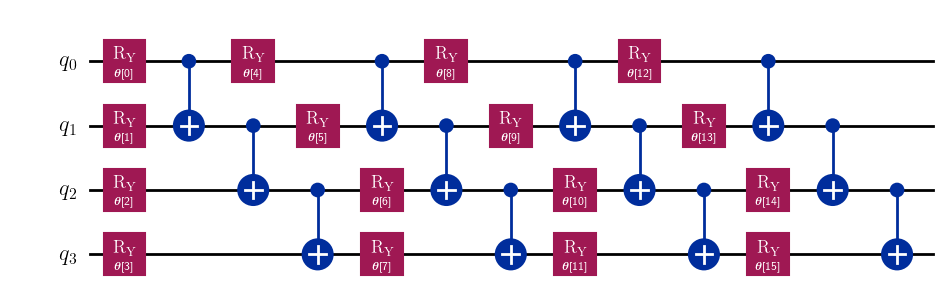

In [ ]:
num_qubits = int(np.log2(grid_num))
ansatz_depth = 4
param_num = num_qubits * ansatz_depth
parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)

psi_param_circuit = make_LNN_ansatz(num_qubits, ansatz_depth, parameters)
print(f"Number of Parameters: {param_num}")
psi_param_circuit.draw('mpl', fold = -1)

### **Fill input_1D**

In [ ]:
def analytic_sol(x: float) -> float:
    return np.sin(np.pi * x)

def f_source(x: float) -> float:
    return -np.pi**2 * np.sin(np.pi * x)

x0 = 0
x1 = 1
x_grid = np.linspace(x0, x1, grid_num + 2, endpoint = True)
x_grid = x_grid[1:-1]
rhs = f_source(x_grid)
np.savetxt("input_1D/rhs.csv", rhs, delimiter=",")

initial_params = np.random.rand(param_num) * 4 * np.pi
np.savetxt("input_1D/initial_params.csv", initial_params, delimiter = ",")

exact = analytic_sol(x_grid)
exact_normalized = exact / np.linalg.norm(exact)

### **Main Code**

In [ ]:
from lib.QuantumCalculator import LaplacianEVProcessor1D, InnerProductProcessor
from lib.QuantumOptimizer import VQA_PoissonOptimizer
from lib.classical_functions import *
from lib.quantum_functions import *
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ionq import IonQProvider
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import SamplerV2 as Sampler, SamplerOptions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import yaml

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# ================================
# Load Configuration
# ================================
print("Loading configuration from config.yaml...")
with open("input_1D/config.yaml", "r") as file:
    config = yaml.safe_load(file)

x0 = config["x0"]
x1 = config["x1"]
grid_num = config["grid_num"]
dx = (x1 - x0) / (grid_num + 1)
ansatz_depth = config["ansatz_depth"]
boundary_condition = config["boundary_condition"]
num_shots = config["num_shots"]
backend = config["backend"]
method = config["method"]

# ================================
# Backend Setup
# ================================
print("Initializing backends...")
if backend == 'simulator':
    # IonQ Simulator
    provider = IonQProvider(os.getenv("IONQ_API_KEY"))
    simulator_backend = provider.get_backend("ionq_simulator", gateset = 'native')
    simulator_backend.set_options(noise_model="ideal")
    
    print(f"Using IonQ simulator: {simulator_backend.name()}")
    used_backend = simulator_backend
    is_simulator = True
    sampler = None
    
elif backend == 'hardware':
    hardware_backend = QiskitRuntimeService().least_busy()
    print(f"Using IBM hardware: {hardware_backend.name}")
    
    # IBM Hardware
    used_backend = hardware_backend
    options_sampler = SamplerOptions()
    options_sampler.default_shots = num_shots
    sampler = Sampler(mode = hardware_backend, options = options_sampler)
    is_simulator = False
else:
    raise ValueError("Invalid backend specified in config.yaml. Choose either 'simulator' or 'hardware'.")

print(f"Configuration:")
print(f"  - x0: {x0}")
print(f"  - x1: {x1}")
print(f"  - grid_num: {grid_num}")

num_qubits = int(np.log2(grid_num))
param_num = num_qubits * ansatz_depth

print(f"  - num_qubits: {num_qubits}, make sure 2 ^ {num_qubits} = grid_num")
print(f"  - ansatz_depth: {ansatz_depth}")
print(f"  - param_num: {param_num}")
print(f"  - num_shots: {num_shots}")
print(f"  - backend: {backend}")
print(f"  - optimization method: {method}")

parameters = ParameterVector(r'$\boldsymbol{\theta}$', length=param_num)
psi_param_circuit = make_LNN_ansatz(num_qubits, ansatz_depth, parameters)

print("Parameterized circuit constructed.")
print(f"  - Number of qubits: {num_qubits}")
print(f"  - Number of parameters: {param_num}")

f_vector = np.loadtxt("input_1D/rhs.csv", delimiter=",")
f_vector = f_vector * dx * dx

if boundary_condition == 'R':
    alpha = config['alpha']
    beta = config['beta']
    gamma = config['gamma']
    print(f"  - boundary_condition: {boundary_condition}")
    print(f"  - Robin boundary condition used -- alpha = {alpha}, beta = {beta}, gamma = {gamma}")
    print("  - Please make sure the following is satisfied in your PDE:")
    print(r"  - $\alpha U_0 + \beta \frac{\partial U_0}{\partial n} = \gamma$")
    print(r"  - $\alpha U_N - \beta \frac{\partial U_N}{\partial n} = \gamma$")
    
    # Dirichlet Correction
    if gamma != 0.0:
        f_vector[0] = f_vector[0] - (gamma / (alpha - (beta / dx)))
        f_vector[-1] = f_vector[-1] - (gamma / (alpha - (beta / dx)))
    
    laplacian_processor = LaplacianEVProcessor1D(
                                ansatz_list=[psi_param_circuit],
                                boundary_condition_list=[boundary_condition],
                                dx_list = [dx],
                                backend=used_backend,
                                num_shots=num_shots,
                                is_simulator = is_simulator,
                                sampler = sampler,
                                alpha = alpha,
                                beta = beta
                           )
    A = laplacian_matrix(n = grid_num,
                     boundary_condition = boundary_condition,
                     alpha = alpha,
                     beta = beta,
                     dx = dx)
    check_stability(A, num_shots)

    
else:
    print(f"  - boundary_condition: {boundary_condition}")
    print("[Warning] Periodic boundary condition leads to a nearly-singular Laplacian operator.")
    print("  -> This can result in poor convergence or unstable optimization in VQA.")
    
    laplacian_processor = LaplacianEVProcessor1D(
                                ansatz_list=[psi_param_circuit],
                                boundary_condition_list=[boundary_condition],
                                dx_list = [dx],
                                backend=used_backend,
                                num_shots=num_shots,
                                is_simulator = is_simulator,
                                sampler = sampler,
                                alpha = 0.0,
                                beta = 0.0
                           )
    
f_normalized = f_vector / np.linalg.norm(f_vector)

numerator_processor = InnerProductProcessor(
        ansatz_list=[psi_param_circuit],
        numerator_list = [f_normalized],
        backend = used_backend,
        num_shots = num_shots,
        is_simulator = is_simulator,
        sampler = sampler
    )

# ================================
# Optimization
# ================================
print("🚀 Starting optimization...")

optimizer = VQA_PoissonOptimizer(
            laplacian_processor = laplacian_processor,
            numerator_processor = numerator_processor)

initial_params = np.loadtxt("input_1D/initial_params.csv", delimiter=",")

result = optimizer.optimize(
            initial_params = initial_params,
            method = method
            )

print("Optimization complete.")

# ================================
# Get Amplitude
# ================================
amplitudes = optimizer.get_amplitudes(optimal_params = result.x)

os.makedirs("output_1D", exist_ok=True)
np.savetxt("output_1D/VQA_optimal_parameters.csv", result.x, delimiter=",")
np.savetxt("output_1D/VQA_optimal_amplitudes.csv", amplitudes, delimiter=",")

with open("output_1D/VQA_result.txt", "w") as f:
    print(result, file=f)

print("Results saved to:")
print("  - output_1D/VQA_optimal_parameters.csv")
print("  - output_1D/VQA_optimal_amplitudes.csv")
print("  - output_1D/VQA_result.txt")

Loading configuration from config.yaml...
Initializing backends...
Using IonQ simulator: ionq_simulator
Configuration:
  - x0: 0.0
  - x1: 1.0
  - grid_num: 16
  - num_qubits: 4, make sure 2 ^ 4 = grid_num
  - ansatz_depth: 4
  - param_num: 16
  - num_shots: 524288
  - backend: simulator
  - optimization method: Powell
Parameterized circuit constructed.
  - Number of qubits: 4
  - Number of parameters: 16
  - boundary_condition: R
  - Robin boundary condition used -- alpha = 0.0, beta = 0.0, gamma = 0.0
  - Please make sure the following is satisfied in your PDE:
  - $\alpha U_0 + \beta \frac{\partial U_0}{\partial n} = \gamma$
  - $\alpha U_N - \beta \frac{\partial U_N}{\partial n} = \gamma$
  - Matrix is well-conditioned. Minimum |<ψ|A|ψ>| = 3.405e-02

🚀 Starting optimization...
Optimization complete.


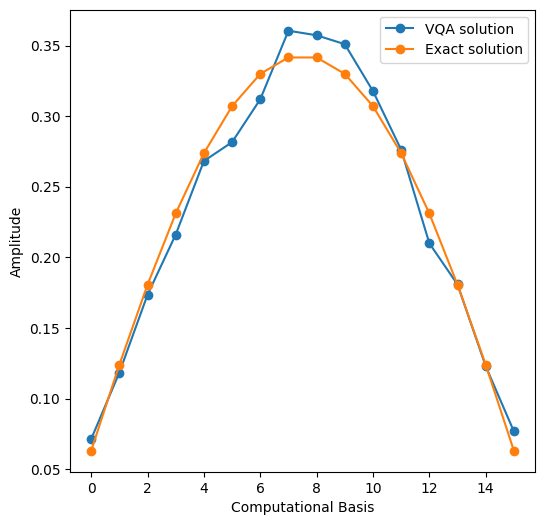

In [9]:
optimal_amp = np.loadtxt("output_1D/VQA_optimal_amplitudes.csv", delimiter=",")

plt.figure(figsize = (6,6))
plt.plot(optimal_amp, marker = 'o', label = 'VQA solution')
plt.plot(exact_normalized, marker = 'o', label = 'Exact solution')
plt.xlabel("Computational Basis")
plt.ylabel("Amplitude")
plt.legend()
plt.show()